In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, recall_score, precision_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [3]:
merged_remove = pd.read_csv('merged_remove.csv')

merged_remove['classification'] = np.where(merged_remove['Crude Opioid Mortality Rate (per 100,000)'] == 0, 0, 1)

In [4]:
# merged_remove['gq_%_of_total_pop'] = merged_remove['GQ Estimates 2016 (count)'] / \
#                                      merged_remove['Population Estimate 2016 (count)'] * 100

In [5]:
merged_remove['%_pop_chg'] = merged_remove['Population Change 2016 (count)'] / \
                                     merged_remove['Population Estimate 2016 (count)'] * 100

In [6]:
merged_remove.drop(columns = ['Population Estimate 2016 (count)', 
                              'GQ Estimates 2016 (count)',
                              'Population Change 2016 (count)'], inplace = True)

In [7]:
y = merged_remove['classification']
X = merged_remove.drop(columns = 'classification')

In [8]:
# set seed for reproducibility
SEED = 123

# split dataset into 80% train and 20% test
X_train, X_test, y_train_clf, y_test_clf = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = SEED)

X_train_clf = X_train.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

X_test_clf = X_test.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

In [9]:
# Stochastic Gradient Boosting Regressor using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbc', xgb.XGBClassifier(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbc_pipeline = Pipeline(steps)

xgbc_param_grid = dict(xgbc__n_estimators = np.arange(2, 500, 10),
                      xgbc__max_depth= np.arange(1, 50, 1),
                      xgbc__subsample= np.arange(0.05, 1, 0.05),
                      xgbc__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbc__learning_rate = np.arange(0.05, 1, 0.05))

xgbc_randomized_recall = RandomizedSearchCV(estimator = xgbc_pipeline, 
                                 param_distributions = xgbc_param_grid, 
                                 scoring = 'recall', 
                                 cv = 5,
                                 n_iter = 1000,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'xgbc_randomized_recall' to the training data
xgbc_randomized_recall.fit(X_train_clf, y_train_clf)

# Extract the best hyperparameters from 'grid_xgbc'
best_hyperparams = xgbc_randomized_recall.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_xgbc'
xgbc_best_model = xgbc_randomized_recall.best_estimator_

recall_score(y_test_clf, xgbc_best_model.predict(X_test_clf))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 17.3min finished


Best hyerparameters:
 {'xgbc__subsample': 0.8500000000000001, 'xgbc__n_estimators': 222, 'xgbc__max_depth': 33, 'xgbc__learning_rate': 0.15000000000000002, 'xgbc__colsample_bytree': 0.5}


0.6714285714285714

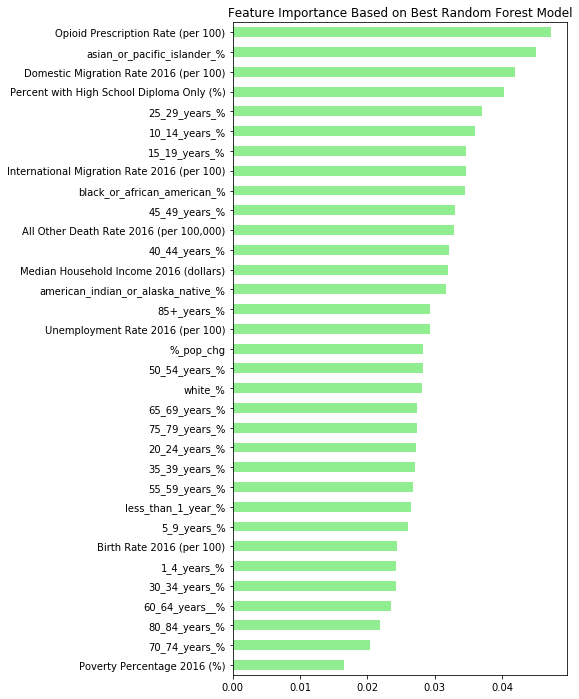

In [10]:
# create a pd.Series of features importances
importances_xgbc = pd.Series(xgbc_best_model.steps[0][1].feature_importances_, index = X_train_clf.columns)

# sort importances_xgbc
sorted_importances_xgbc = importances_xgbc.sort_values()

# make a horizontal bar plot
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 12))
sorted_importances_xgbc.plot(kind = 'barh', color = 'lightgreen', ax=ax)
ax.set_title('Feature Importance Based on Best Random Forest Model')
f.show()

In [11]:
# def Find_Optimal_Cutoff(target, predicted):
#     """ Find the optimal probability cutoff point for a classification model related to event rate
#     Parameters
#     ----------
#     target : Matrix with dependent or target data, where rows are observations

#     predicted : Matrix with predicted data, where rows are observations

#     Returns
#     -------     
#     list type, with optimal cutoff value

#     """
#     fpr, tpr, threshold = roc_curve(target, predicted)
#     i = np.arange(len(tpr)) 
#     roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
#     roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

#     return list(roc_t['threshold']) 

# # Find optimal probability threshold
# threshold = Find_Optimal_Cutoff(y_train_clf, xgbc_best_model.predict(X_train_clf)[:,1])
# print(threshold)
# # [0.31762762459360921]

In [12]:
# # Find prediction to the dataframe applying threshold
# predicted = pd.Series(xgbc_best_model.predict(X_train_clf)[:,1]).map(lambda x: 1 if x > threshold[0] else 0)

# # Print confusion Matrix
# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_train_clf, predicted)
# # array([[175,  98],
# #        [ 46,  81]])

In [13]:
predictions_best_model_train = xgbc_best_model.predict(X_train_clf)
predictions_best_model_test = xgbc_best_model.predict(X_test_clf)

In [14]:
X_train_true_predict = X_train[predictions_best_model_train == 1]

X_test_true_predict = X_test[predictions_best_model_test == 1]

In [15]:
X_train_reg = X_train_true_predict.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

In [16]:
y_train_reg = X_train_true_predict['Crude Opioid Mortality Rate (per 100,000)']

In [17]:
X_test_reg = X_test_true_predict.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

In [18]:
y_test_reg = X_test_true_predict['Crude Opioid Mortality Rate (per 100,000)']

In [19]:
# Stochastic Gradient Boosting Regressor using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbr', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbr_pipeline = Pipeline(steps)

xgbr_param_grid = dict(xgbr__n_estimators = np.arange(2, 500, 10),
                      xgbr__max_depth= np.arange(1, 50, 1),
                      xgbr__subsample= np.arange(0.05, 1, 0.05),
                      xgbr__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbr__learning_rate = np.arange(0.05, 1, 0.05))

xgbr_randomized_neg_mse = RandomizedSearchCV(estimator = xgbr_pipeline, 
                                 param_distributions = xgbr_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = 1000,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'grid_xgbr' to the training data
xgbr_randomized_neg_mse.fit(X_train_reg, y_train_reg)

# Extract the best hyperparameters from 'grid_xgbr'
best_hyperparams = xgbr_randomized_neg_mse.best_params_

print('Best hyerparameters:\n', best_hyperparams)

# extract best model from 'grid_xgbr'
xgbr_best_model = xgbr_randomized_neg_mse.best_estimator_

# predict the test set labels
y_pred = xgbr_best_model.predict(X_test_reg)

# Compute rmse_test
rmse_test = MSE(y_test_reg, y_pred)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 575 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 925 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1375 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2903 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3690 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 4777 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  6.9min finished


Best hyerparameters:
 {'xgbr__subsample': 0.7500000000000001, 'xgbr__n_estimators': 122, 'xgbr__max_depth': 6, 'xgbr__learning_rate': 0.05, 'xgbr__colsample_bytree': 0.6500000000000001}
Test RMSE of best model: 12.088


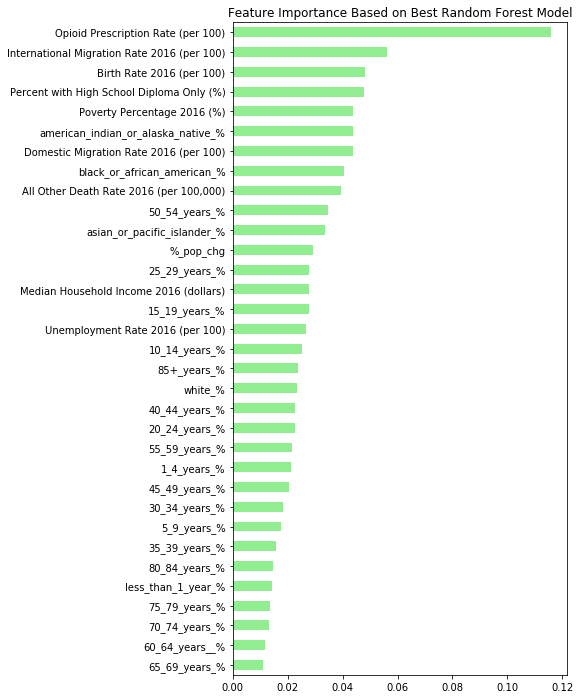

In [20]:
# create a pd.Series of features importances
importances_xgbr = pd.Series(xgbr_best_model.steps[0][1].feature_importances_, index = X_train_clf.columns)

# sort importances_xgbr
sorted_importances_xgbr = importances_xgbr.sort_values()

# make a horizontal bar plot
f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 12))
sorted_importances_xgbr.plot(kind = 'barh', color = 'lightgreen', ax=ax)
ax.set_title('Feature Importance Based on Best Random Forest Model')
f.show()

In [21]:
predictions_best_model_test = xgbc_best_model.predict(X_test_clf)

X_test_true_predict = X_test[predictions_best_model_test == 1]

X_test_reg = X_test_true_predict.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

y_test_reg = X_test_true_predict['Crude Opioid Mortality Rate (per 100,000)']

In [22]:
# Predict Opioid Overdose Mortality Rate for All Counties Using Best Model

In [23]:
X_no_opioid_mortality = X.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

merged_data = pd.read_csv('merged_data.csv')

merged_data['classification_predict_proba'] = xgbc_best_model.predict_proba(X_no_opioid_mortality)[:, 1]

merged_data['classification_prediciton'] = xgbc_best_model.predict(X_no_opioid_mortality)

merged_data['clf_reg_prediction'] = merged_data['classification_prediciton']

merged_data.loc[merged_data.classification_prediciton == 1, 'clf_reg_prediction'] = \
                                xgbr_best_model.predict(X_no_opioid_mortality.loc[merged_data.classification_prediciton == 1])

In [24]:
merged_data.sort_values(by = 'crude_opioid_mortality_rate', ascending = False).head()

,fips_code,population,crude_opioid_mortality_rate,state,opioid_prescription_rate,%_povall_2016,pop_chg_2016,gq_estimates_2016,rate_birth_2016,rate_international_mig_2016,...,65_69_years_%,70_74_years_%,75_79_years_%,80_84_years_%,85+_years_%,less_than_1_year_%,county,classification_predict_proba,classification_prediciton,clf_reg_prediction
989,21097,18646.0,118.0,KY,96.3,15.0,-48.0,275.0,12.142704,1.128304,...,5.926204,3.984769,3.207122,2.091601,1.791269,1.190604,Harrison,0.982375,1,108.549774
2819,54011,95987.0,90.6,WV,122.3,22.0,-793.0,4077.0,11.065367,0.718260,...,5.939346,4.110973,3.100420,2.286768,2.275308,1.177243,Cabell,0.980744,1,84.218765
2863,54099,40531.0,83.9,WV,67.5,22.0,-507.0,246.0,9.942956,0.000000,...,6.807135,4.746984,3.508426,2.304409,2.193383,0.994301,Wayne,0.957964,1,79.465538
2843,54059,24647.0,81.1,WV,96.5,28.0,-601.0,85.0,11.810630,0.000000,...,6.816245,3.874711,2.844160,1.858238,1.432223,1.294275,Mingo,0.964067,1,78.810020
1162,24510,614664.0,76.1,MD,54.6,22.0,-6073.0,26089.0,13.672702,3.695194,...,4.671821,2.934449,2.104727,1.504074,1.652285,1.384822,Baltimore City,0.990666,1,68.810555


In [25]:
# overall mse using best model
np.sqrt(np.mean((merged_data.crude_opioid_mortality_rate - merged_data.clf_reg_prediction)**2))

3.9690301610224816

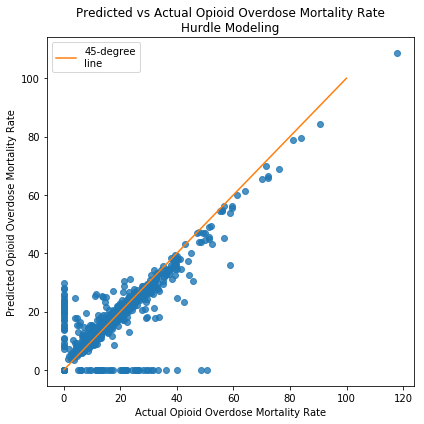

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

_ = sns.regplot(y = merged_data.clf_reg_prediction, x = merged_data.crude_opioid_mortality_rate, fit_reg = False, ax = ax)
_ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
_ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
_ = ax.set_title('Predicted vs Actual Opioid Overdose Mortality Rate\nHurdle Modeling')
_ = ax.plot([0, 100], [0, 100]) # 45 degree line
_ = ax.legend(['45-degree\nline'], frameon = True)

fig.tight_layout()
fig.savefig('images/predicted_actual_hurdle_modeling.png')
fig.show()

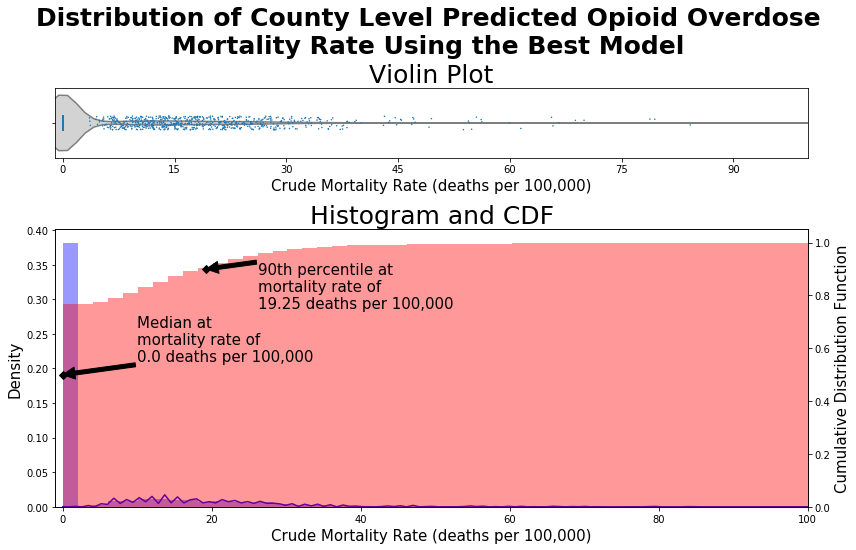

In [27]:
# Calculate number of bins to use for histogram
# Number of bins is the square root of number of data points: n_bins
n_data = len(merged_data.clf_reg_prediction)
n_bins = np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Cut the figure in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, gridspec_kw={"height_ratios": (.2, .8)}, figsize = (12, 8))

# Add violinplot to first subplot
sns.violinplot(merged_data.clf_reg_prediction, inner = None, color = 'lightgray', ax = ax_box)
sns.stripplot(merged_data.clf_reg_prediction, size = 1.5, jitter = True, ax = ax_box)

# Set x-axis name for the violinplot
ax_box.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
# Set x-axis range
ax_box.set_xlim((-1, 100))
# Set number of tickmarks for x-axis
ax_box.xaxis.set_major_locator(plt.MaxNLocator(9))
# Set title for violinplot
ax_box.set_title("Violin Plot", fontsize = 25)

# Add histogram to second subplot
sns.distplot(merged_data.clf_reg_prediction, color = 'blue', bins = n_bins, ax=ax_hist)

# Have an overlaying plot for second subplot
ax_hist2 =ax_hist.twinx()

# Overlay ecdf to histogram
sns.distplot(merged_data.clf_reg_prediction, 
             color = 'red', 
             bins= n_bins, 
             kde_kws = dict(cumulative = True), 
             hist_kws=dict(cumulative=True), 
             ax=ax_hist2)

# Calculate median for cdf
median = np.percentile(merged_data.clf_reg_prediction, 50)
# Plot point at median
_ = plt.plot(median, .5, marker='D', color='black',
         linestyle='none')
# Add arrow at median with text
ax_hist2.annotate('Median at\nmortality rate of\n{} deaths per 100,000'.format(median), 
                  xy=(median, .5), 
                  xytext=(median + 10, 0.55),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Calculate 90th percentile for cdf
percentile_90th = np.percentile(merged_data.clf_reg_prediction, 90)
# Plot point at 90th percentile
_ = plt.plot(percentile_90th, .9, marker='D', color='black',
         linestyle='none')
# Add arrow at 90th percentile with text
ax_hist2.annotate('90th percentile at\nmortality rate of\n{} deaths per 100,000'.format(round(percentile_90th, 2)), 
                  xy=(percentile_90th, .9), 
                  xytext=(percentile_90th + 7, 0.75),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Set x-axis limit for histogram
ax_hist.set_xlim((-1, 100))

# Add axis labels for histogram and cdf
ax_hist.set_title("Histogram and CDF", fontsize = 25)
ax_hist.set_ylabel('Density', fontsize = 15)
ax_hist.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
ax_hist2.set_ylabel('Cumulative Distribution Function', fontsize = 15)

# Add title to figure
f.suptitle('Distribution of County Level Predicted Opioid Overdose\nMortality Rate Using the Best Model', 
           fontsize = 25, fontweight = 'bold')

# Adjust plot layout
f.tight_layout(rect = [0, 0.03, 1, 0.9])
f.show()

In [28]:
# merged_data['gq_%_of_total_pop'] = merged_remove['gq_%_of_total_pop']
merged_data['%_pop_chg'] = merged_remove['%_pop_chg']

In [29]:
merged_data.sort_values(by = 'crude_opioid_mortality_rate', ascending = False).head(10).T

,989,2819,2863,2843,1162,1716,2815,724,1137,981
fips_code,21097,54011,54099,54059,24510,35039,54003,18143,23029,21081
population,18646,95987,40531,24647,614664,40040,113525,23730,31450,24923
crude_opioid_mortality_rate,118,90.6,83.9,81.1,76.1,72.4,72.2,71.6,70,64.2
state,KY,WV,WV,WV,MD,NM,WV,IN,ME,KY
opioid_prescription_rate,96.3,122.3,67.5,96.5,54.6,83,90.2,149,64.3,106.8
%_povall_2016,15,22,22,28,22,23,13,16,18,16
pop_chg_2016,-48,-793,-507,-601,-6073,-129,1773,49,-181,174
gq_estimates_2016,275,4077,246,85,26089,425,889,312,790,456
rate_birth_2016,12.1427,11.0654,9.94296,11.8106,13.6727,13.1557,12.0747,12.8787,9.28719,14.1815
rate_international_mig_2016,1.1283,0.71826,0,0,3.69519,0.815858,-0.0444905,0.844505,0.821316,-0.0805769
